In [1]:
import pandas as pd
import numpy as np

class Load_Balancer:
    def __init__(self, beta,number_of_servers,number_of_task):
        self.number_of_task=number_of_task
        self.number_of_servers=number_of_servers
        self.processing = {t:self.processing_time(beta=beta) for t in range(self.number_of_task)}
        self.arrival_times = self.inter_arrival_times(q=3 / 5, T0=1, mean_Y=10, N=self.number_of_task)
        self.servers = {i: {"que": [], "proces": 0 ,"processing_task":0} for i in range(0, number_of_servers)}
        self.task = {i:{"sum":0,"entrance_time": 0, "quiting_time": 0,
                        "processing_time":self.processing[i],"arrival_time":self.arrival_times[i],
                        "server":0} for i in range(len(self.processing))}
        self.is_server_bt = [1]*20
        self.global_time=0
        self.current_task=0
        self.next_arriving_time=0
        self.threshold=1
        self.d=3
        self.time_interval_update = 1000
        self.msg_cont = 0

    def inter_arrival_times(self,q, T0, mean_Y, N):
        inter_times = {}
        for i in range(N):
            r = np.random.random()
            if r <= q:
                T = T0
            else:
                T = T0 - mean_Y * np.log(np.random.random())
            inter_times[i] = int(round(T))
        return (inter_times)

    def processing_time(self,beta):
        expected_service_time = beta * 2
        r = np.random.random()
        confront_min = []
        confront_min.append(round(np.log(r) * np.log(r) * beta))
        confront_min.append(100 * expected_service_time)
        min_temp = min(confront_min)
        confront_max = []
        confront_max.append(1)
        confront_max.append(int(min_temp))
        weibell_rv = max(confront_max)
        return (weibell_rv)

    def iterate_one_task_JSQ(self):
        min_que_holder = float("+inf")
        min_que_server = 0

        for server in self.servers:
            is_processing = 1 if self.servers[server]["proces"] else 0
            if len(self.servers[server]["que"]) + is_processing < min_que_holder:
                min_que_holder = len(self.servers[server]["que"])+is_processing
                min_que_server = server
        self.task[self.current_task]["server"]=min_que_server
        self.servers[min_que_server]["que"].append(self.current_task)
        if self.servers[min_que_server]["proces"] == 0:
            item_in_proces=self.servers[min_que_server]["que"].pop(0)
            self.servers[min_que_server]["proces"]=self.processing[item_in_proces]
            self.servers[min_que_server]["processing_task"] = item_in_proces

        self.task[self.current_task]["entrance_time"] = self.global_time
        self.current_task += 1
        try:
            self.next_arriving_time=self.arrival_times[self.current_task]
        except:
            #print("Last Element")
            self.next_arriving_time=self.arrival_times[self.current_task -1 ]
    
    
    def iterate_one_task_JBT(self):
        
        ''' the following part is new respect to Vedat's '''
        available_servers = []
        # check which servers have threshold below t and append them in the list below
        for server in range(self.number_of_servers) :
            if self.is_server_bt[server] == 1:
                available_servers.append(server)
        # if there are no servers below th then select a random server
        if len(available_servers) == 0:
            random_server = np.random.randint(0,self.number_of_servers)
        else:
        # otherwise select one of the servers that are below treshold
            random_index_server = np.random.randint(0,len(available_servers))
            random_server = available_servers[random_index_server]

        self.is_server_bt[random_server] = 0
        self.servers[random_server]['que'].append(self.current_task)
        self.task[self.current_task]['server'] = random_server
        
        ''' the following part is new respect to Vedat's '''
        if self.servers[random_server]["proces"] == 0:
            item_in_proces=self.servers[random_server]["que"].pop(0)
            self.servers[random_server]["proces"]=self.processing[item_in_proces]
            self.servers[random_server]["processing_task"] = item_in_proces
            # if the que is less than threshold put it in the list of servers that are below threshold
            if len(self.servers[random_server]['que']) <= self.threshold:
                if self.is_server_bt[random_server] == 0:
                    self.msg_cont += 1
                    self.is_server_bt[random_server] = 1

        self.task[self.current_task]["entrance_time"] = self.global_time
        self.current_task += 1
        try:
            self.next_arriving_time=self.arrival_times[self.current_task]
        except:
            #print("Last Element")
            self.next_arriving_time=self.arrival_times[self.current_task -1 ]  
    
    def iterate_one_task_POD (self):
        Len_of_Random_Selected_Que_List = list()
        num_of_shortest_que_server=0
        num_task_shortest_que= self.number_of_task
        sampling = np.random.randint(0,self.number_of_servers, size=self.d)
        for i in range(self.d):
            Len_of_Random_Selected_Que_List.append((sampling[i],len(self.servers[sampling[i]]['que'])))
    
        for i in range(len(Len_of_Random_Selected_Que_List)):
            if (Len_of_Random_Selected_Que_List[i][1] <= num_task_shortest_que):
                num_task_shortest_que = Len_of_Random_Selected_Que_List[i][1]
                min_que_server = Len_of_Random_Selected_Que_List[i][0]
                
        self.task[self.current_task]["server"]=min_que_server
        self.servers[min_que_server]["que"].append(self.current_task)
        if self.servers[min_que_server]["proces"] == 0:
            item_in_proces=self.servers[min_que_server]["que"].pop(0)
            self.servers[min_que_server]["proces"]=self.processing[item_in_proces]
            self.servers[min_que_server]["processing_task"] = item_in_proces

        self.task[self.current_task]["entrance_time"] = self.global_time
        self.current_task += 1
        try:
            self.next_arriving_time=self.arrival_times[self.current_task]
        except:
            #print("Last Element")
            self.next_arriving_time=self.arrival_times[self.current_task -1 ]
    
    
    
    
    def iterate_over_global_time_JBT(self):
        for time in range(self.next_arriving_time):
            self.global_time += 1
            for server in self.servers:
                if self.servers[server]["proces"] > 0:
                    self.servers[server]["proces"] -= 1
                    if self.servers[server]["proces"] == 0:
                        self.task[self.servers[server]["processing_task"]]["quiting_time"]=self.global_time
                        if len(self.servers[server]["que"]) > 0 :
                            item_in_proces=self.servers[server]["que"].pop(0)
                            self.servers[server]["proces"] = self.processing[item_in_proces]
                            self.servers[server]["processing_task"] = item_in_proces     
                            
                ''' the following part is new respect to Vedat's '''
                # at each time verify the que lenghts and update the list
                if len(self.servers[server]['que']) <= self.threshold:
                    if self.is_server_bt[server] == 0:
                        self.is_server_bt[server]=1
                        self.msg_cont += 1
            
            '''updating of the threshold'''
            
            # at multiple of time_interval_update we update the treshold
            if self.global_time % self.time_interval_update == 0:
                # take d random servers
                random_d_servers = np.random.randint(0,self.number_of_servers, size =self.d)
                random_d_servers_ques = []
                # for each of the servesr check their queue and take the minimum value and put it as threshold
                for server in random_d_servers:
                    random_d_servers_ques.append(len(self.servers[server]['que']))
                self.threshold = min(random_d_servers_ques)
                self.msg_cont += 2*self.d + self.number_of_servers
                is_server_bt = [0]*self.number_of_servers
                for server in self.servers:
                    if len(self.servers[server]['que']) <= self.threshold:
                        self.is_server_bt[server]=1
                        #self.msg_cont += 1
                #print("th: ",self.threshold)
    
    
    
    def iterate_over_global_time(self):
        for time in range(self.next_arriving_time):
            self.global_time += 1
            for server in self.servers:
                if self.servers[server]["proces"] > 0:
                    self.servers[server]["proces"] -= 1
                    if self.servers[server]["proces"] == 0:
                        self.task[self.servers[server]["processing_task"]]["quiting_time"]=self.global_time
                        if len(self.servers[server]["que"]) > 0 :
                            item_in_proces=self.servers[server]["que"].pop(0)
                            self.servers[server]["proces"] = self.processing[item_in_proces]
                            self.servers[server]["processing_task"] = item_in_proces

    def finishing_all_the_task(self):
        for server in self.servers:
            initial_global_for_each_server=self.global_time
            while len(self.servers[server]["que"]) :
                #print(self.servers[server]["proces"])
                if self.servers[server]["proces"] > 0:
                    initial_global_for_each_server += self.servers[server]["proces"]
                    self.task[self.servers[server]["processing_task"]]["quiting_time"] = initial_global_for_each_server
                    next_item_in_que=self.servers[server]["que"].pop(0)
                    self.servers[server]["processing_task"]=next_item_in_que
                    self.servers[server]["proces"]=self.processing[next_item_in_que]
            initial_global_for_each_server += self.servers[server]["proces"]
            self.task[self.servers[server]["processing_task"]]["quiting_time"] = initial_global_for_each_server
            self.servers[server]["processing_task"] = "nothing_left"
            self.servers[server]["proces"] = "idle"


    def	main(self):
        for i in range(self.number_of_task):
            load_balance.iterate_one_task_JBT()
            load_balance.iterate_over_global_time_JBT()

        load_balance.finishing_all_the_task()

In [2]:
if __name__ == "__main__":
    final_times = []
    final_msg = []
    B = 50
    for m in range(B):
       # print()
        avg_times=[]
        msg=[]
        for b in [49.5]:
            print(m,'---',b)
            load_balance=Load_Balancer(beta=b,number_of_servers=20,number_of_task=200000)
            load_balance.main()
            df=pd.DataFrame.from_dict(load_balance.task,orient="index")
            df["sum"]=df["quiting_time"]-df["entrance_time"]
            avg_times.append(df[10000:190000]['sum'].mean())
            msg.append(load_balance.msg_cont/200000)
        final_times.append(avg_times)
        final_msg.append(msg)
    final_times_df = pd.DataFrame(final_times)
    final_msg_df = pd.DataFrame(final_msg)
    final_times_df.to_csv('dilara_sim_last.csv', index=False)

0 --- 49.5
1 --- 49.5
2 --- 49.5
3 --- 49.5
4 --- 49.5
5 --- 49.5
6 --- 49.5
7 --- 49.5
8 --- 49.5
9 --- 49.5
10 --- 49.5
11 --- 49.5
12 --- 49.5
13 --- 49.5
14 --- 49.5
15 --- 49.5
16 --- 49.5
17 --- 49.5
18 --- 49.5
19 --- 49.5
20 --- 49.5
21 --- 49.5
22 --- 49.5
23 --- 49.5
24 --- 49.5
25 --- 49.5
26 --- 49.5
27 --- 49.5
28 --- 49.5
29 --- 49.5
30 --- 49.5
31 --- 49.5
32 --- 49.5
33 --- 49.5
34 --- 49.5
35 --- 49.5
36 --- 49.5
37 --- 49.5
38 --- 49.5
39 --- 49.5
40 --- 49.5
41 --- 49.5
42 --- 49.5
43 --- 49.5
44 --- 49.5
45 --- 49.5
46 --- 49.5
47 --- 49.5
48 --- 49.5
49 --- 49.5


In [ ]:
[40,41,42,43,44,45,46,47,48,49,49.5]

In [ ]:
[48.5,49.25]

In [ ]:
[47.5, 48.75, 49.375]

In [245]:
rho = np.array([40,41,42,43,44,45,46,47,47.5,48,48.5,48.75,49,49.25,49.375,49.5])/50

In [257]:
a = pd.read_csv('Dilara_sim.csv')
b = pd.read_csv('Dilara_sim2.csv')
c = pd.read_csv('dilara_sim_3.csv')

In [258]:
temp1 = a.loc[:,['0','1','2','3','4','5','6','7']]
temp1['8'] = c['0']
temp1['9'] = a['8']
temp1['10'] = b['0']
temp1['11'] = c['1']
temp1['12'] = a['9']
temp1['13'] = b['1']
temp1['14'] = c['2']
temp1['15'] = a['10']

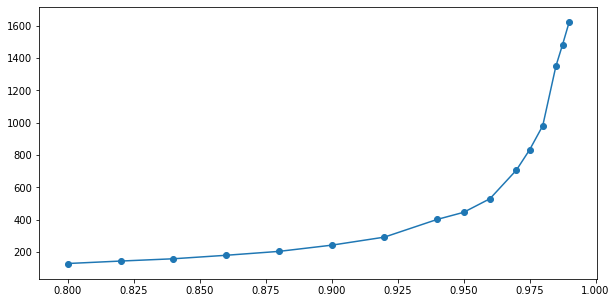

In [259]:
plt.figure(figsize=(10,5))
plt.plot(rho,temp1.mean())
plt.scatter(rho,temp1.mean())

In [261]:
temp1.to_csv('jsq.csv', index=False)